In [1]:
%load_ext autoreload
import sys
sys.path.append('../../..')
import numpy as np

import config
import main_components as main
import pickle
import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

In [2]:
### SETTINGS TO CHANGE
output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'
results_comp = pickle.load(open(output_dir+f'component_distortions.p','rb'))

# Generate data, if not loading previous

In [3]:
# Parameters
nmax = 10
iterations = 5
start_rs, high_rs, end_rs = 3e3, 1.555e3, 4
cf = 16
rtol = 1e-6

# DM model
pri, DM_process = 'elec', 'decay'
mDM = 2e8
lifetime=2e25

In [4]:
# %autoreload
# results_comp = main.evolve(
#     DM_process=DM_process, mDM=mDM,
#     lifetime=lifetime,
#     primary=pri+'_delta',
#     start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
#     reion_switch=True, reion_method='Puchwein', heat_switch=True,
#     coarsen_factor=cf, rtol=rtol,
#     distort=True, fexc_switch = True, 
#     reprocess_distortion=True, 
#     nmax=nmax, iterations=iterations
# )

# pickle.dump(results_comp, open(output_dir+'component_distortions.p', 'wb'))

# Get separate distortion components

In [5]:
# Dictionary that collects all of the separate components of the distortion
components = {}

In [6]:
# ICS component
ICS_component = results_comp[-1]['lowengphot'].copy()
ICS_component._grid_vals *= list(map(int, ICS_component.eng < phys.rydberg))
ICS_component.redshift(1)
components['ICS'] = {'distortion': ICS_component.sum_specs()}

In [7]:
# Reionization and recombination components
weights_recomb = (results_comp[-1]['lowengphot'].rs > 400)
weights_reion = results_comp[-1]['lowengphot'].rs < 400

atomic_component = results_comp[-1]['dist_atomic'].copy()
atomic_component.redshift(1)
components['recomb'] = {'distortion': atomic_component.sum_specs(weight=weights_recomb)}
components['reion'] = {'distortion': atomic_component.sum_specs(weight=weights_reion)}

In [8]:
# y-type from heating
yheat_component = results_comp[-1]['dist_yheat'].copy()
yheat_component.redshift(1)

# rs_inds, = np.where(results_comp['dist_yheat'].rs < 15)
# cmap = cm.plasma(np.linspace(0.2,0.85,len(rs_inds)))
# plt.figure(figsize=(7,7))
# plt.xscale('log')
# for i, ind in enumerate(rs_inds):
#     plt.plot(yheat_component[ind].eng, yheat_component[ind].dNdE*yheat_component[ind].eng, color=cmap[i], alpha=0.2)
# plt.xlim(1e-5,1e-2)
# plt.show()

components['y_heat'] = {'distortion': yheat_component.sum_specs()}

In [9]:
### Check that sum of components is equal to total distortion
# total_spec = Spectrum(components['ICS']['distortion'].eng, 
#                       np.zeros_like(components['ICS']['distortion'].eng), 
#                       rs=1, spec_type='N')

# components['recomb']['distortion'].rebin(components['ICS']['distortion'].eng)
# components['reion']['distortion'].rebin(components['ICS']['distortion'].eng)
# components['y_heat']['distortion'].rebin(components['ICS']['distortion'].eng)

# total_spec.N += components['ICS']['distortion'].N
# total_spec.N += components['recomb']['distortion'].N
# total_spec.N += components['reion']['distortion'].N
# total_spec.N += components['y_heat']['distortion'].N

# components['total'] = {'distortion': total_spec}

# Plot

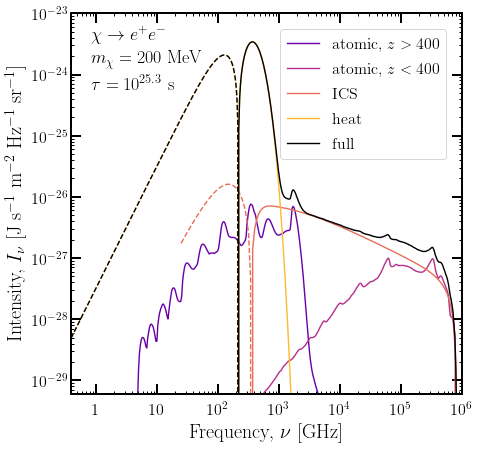

In [10]:
cmap = cm.plasma(np.linspace(0.2,0.85,4))

plt.figure(figsize=(7,7))
ax = plt.gca()

plot_distortion(ax, components['recomb'], label=r'atomic, $z > 400$',
                color=cmap[0], leg=True, first=False)
plot_distortion(ax, components['reion'], label=r'atomic, $z < 400$',
                color=cmap[1], leg=True, first=False)
plot_distortion(ax, components['ICS'], label='ICS',
                color=cmap[2], leg=True, first=False)
plot_distortion(ax, components['y_heat'], label='heat',
                color=cmap[3], leg=True, first=False)
# plot_distortion(ax, components['total'], label='sum?',
#                 color='grey', leg=True, first=False)
plot_distortion(ax, results_comp[-1], label='full', color='k', leg=True, first=False)

plt.ylim(6e-30, 1e-23)
plt.text(0.05, 0.93, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes)
plt.text(0.05, 0.86, r'$m_\chi = 200$ MeV', fontsize=18, transform = ax.transAxes)
plt.text(0.05, 0.8, r'$\tau = 10^{25.3}$ s', fontsize=18, transform = ax.transAxes)

plt.savefig(fig_dir+'components.pdf')
plt.show()

# Plot contribution from each redshift for ICS+heating

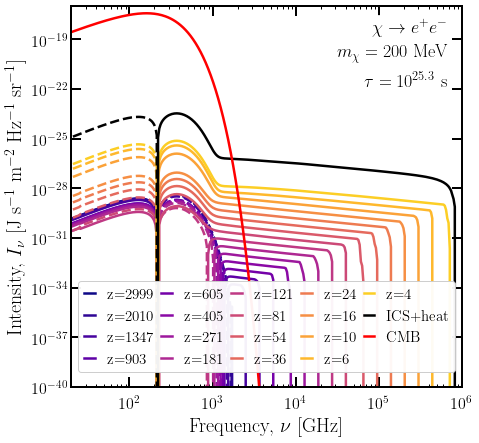

In [13]:
skip = 25
hplanck = phys.hbar * 2*np.pi
color = cm.plasma(np.linspace(0.,.9,len(results_comp[-1]['lowengphot'].rs[::skip])))

plt.figure(figsize=(7,7))
plt.loglog()
ax = plt.gca()

# Plot contribution to distortion from every 20th redshift step
for ii, rs in enumerate(results_comp[-1]['lowengphot'].rs[::skip]):
    ICS_dNdE = np.interp(yheat_component[ii*skip].eng, 
                         ICS_component[ii*skip].eng, 
                         ICS_component[ii*skip].dNdE, 
                         left=0, right=0)
    plt.plot(yheat_component[ii*skip].eng / hplanck / 1e9, 
             ICS_dNdE * phys.nB * yheat_component[ii*skip].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4
             + yheat_component[ii*skip].dNdE * phys.nB * yheat_component[ii*skip].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4, 
             label=f'z={rs-1:.0f}', color=color[ii])
    plt.plot(yheat_component[ii*skip].eng / hplanck / 1e9, 
             - ICS_dNdE * phys.nB * yheat_component[ii*skip].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4
             - yheat_component[ii*skip].dNdE * phys.nB * yheat_component[ii*skip].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4, 
             linestyle='--', color=color[ii])

# Plot the sum of the ICS and heating contributions
ICS_tot_dNdE = np.interp(components['y_heat']['distortion'].eng, 
                         components['ICS']['distortion'].eng, 
                         components['ICS']['distortion'].dNdE, 
                         left=0, right=0)
plt.plot(components['y_heat']['distortion'].eng / hplanck / 1e9, 
         ICS_tot_dNdE * phys.nB * components['y_heat']['distortion'].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4
         + components['y_heat']['distortion'].dNdE * phys.nB * components['y_heat']['distortion'].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4, 
         label='ICS+heat', color='k')
plt.plot(components['y_heat']['distortion'].eng / hplanck / 1e9, 
         - ICS_tot_dNdE * phys.nB * components['y_heat']['distortion'].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4
         - components['y_heat']['distortion'].dNdE * phys.nB * components['y_heat']['distortion'].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4, 
         linestyle='--', color='k')

# Plot CMB blackbody spectrum, scaled to be visible on the plot
plt.plot(yheat_component.eng / hplanck / 1e9, 
         phys.CMB_spec(yheat_component.eng, phys.TCMB(1)) * yheat_component[ii*skip].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4, 
         label=r'CMB', color='r')

plt.axis([20, 1e6, 1e-40, 1e-17])
plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
plt.text(0.77, 0.93, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.68, 0.86, r'$m_\chi = 200$ MeV', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.75, 0.79, r'$\tau = 10^{25.3}$ s', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.legend(loc='lower center', ncol=5, handlelength=0.7, fontsize=15, 
           columnspacing=0.5, framealpha=0.95)

#plt.vlines(phys.rydberg / hplanck / 1e9 / 4, 1e-38, 1e-25, linewidth=1,  color='gray', linestyle=':')
plt.savefig(fig_dir+'redshift_dists.pdf')
plt.show()

# Plot contribution from each redshift from atomic

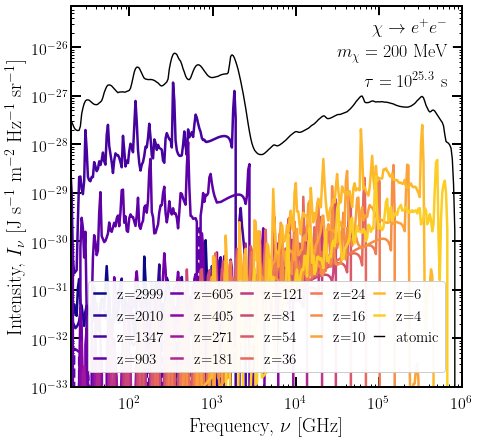

In [14]:
skip = 25
hplanck = phys.hbar * 2*np.pi
color = cm.plasma(np.linspace(0.,.9,len(results_comp[-1]['lowengphot'].rs[::skip])))

plt.figure(figsize=(7,7))
plt.loglog()
ax = plt.gca()

# Plot contribution to distortion from every 20th redshift step
for ii, rs in enumerate(results_comp[-1]['lowengphot'].rs[::skip]):
    plt.plot(atomic_component[ii*skip].eng / hplanck / 1e9, 
             atomic_component[ii*skip].dNdE * phys.nB * atomic_component[ii*skip].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4, 
             label=f'z={rs-1:.0f}', color=color[ii])
    plt.plot(atomic_component[ii*skip].eng / hplanck / 1e9, 
             - atomic_component[ii*skip].dNdE * phys.nB * atomic_component[ii*skip].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4, 
             linestyle='--', color=color[ii])

# Plot the sum of the ICS and heating contributions
components['atomic'] = {'distortion' : components['recomb']['distortion'] + components['reion']['distortion']}
plot_distortion(ax, components['atomic'], label='atomic', color='k', first=False)

plt.axis([20, 1e6, 1e-33, 7e-26])
plt.text(0.77, 0.93, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.68, 0.86, r'$m_\chi = 200$ MeV', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.75, 0.79, r'$\tau = 10^{25.3}$ s', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.legend(loc='lower center', ncol=5, handlelength=0.7, fontsize=15, 
           columnspacing=0.5, framealpha=0.95)

#plt.vlines(phys.rydberg / hplanck / 1e9 / 4, 1e-38, 1e-25, linewidth=1,  color='gray', linestyle=':')
plt.savefig(fig_dir+'redshift_dists_atomic.pdf')
plt.show()